In [1]:
# =================================================
# 0. Install Dependencies for Offline Translation
# =================================================
# Install the latest stable PyTorch version (2.6+) to resolve security vulnerability
!pip install --upgrade torch>=2.6.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --upgrade transformers accelerate sentencepiece sacrebleu

print("Upgraded torch to version 2.6+ and installed required packages for offline translation.")

Upgraded torch to version 2.6+ and installed required packages for offline translation.


In [3]:
# Check torch version after upgrade
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


# Marathi Tweet Sentiment Analysis with SentiWordNet

This notebook combines two Marathi sentiment datasets (MahaSent Movie Reviews and MahaSent Social Tweets), translates Marathi text to English, applies a rule-based sentiment classifier using SentiWordNet, evaluates performance, and visualizes results with word clouds and confusion matrices.

## Pipeline Overview
1. Load and unify datasets (movie reviews + social tweets)
2. Clean and deduplicate
3. Translate Marathi → English with caching
4. Tokenize and score using SentiWordNet
5. Predict sentiment labels (positive / negative / neutral)
6. Evaluate against gold labels
7. Visualize (word clouds, label distributions, confusion matrix)
8. Save merged results, metrics, artifacts

## Why Rule-Based First?
Using SentiWordNet provides a transparent baseline. Later you can compare with ML models (Naive Bayes, SVM) or transformer-based IndicBERT / mBERT fine-tuning.

---
**Note:** Translation quality affects downstream scoring; idioms or domain phrases may reduce accuracy. Caching limits repeated API usage.

In [9]:
# =====================
# 1. Setup: Imports & Configuration
# =====================
import os
import re
import json
import time
import math
import random
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# ML/DL Frameworks for Offline Translation
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import nltk
from nltk.corpus import sentiwordnet as swn, stopwords, wordnet
from nltk import pos_tag, word_tokenize

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# --- GPU / Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Translation & caching configuration
BLOCK_SIZE = 16  # Adjusted for GPU memory
CACHE_SAVE_INTERVAL = 100
TRANSLATION_CACHE_PATH = Path('translation_cache_offline.json') # Use a different cache file
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

# NLTK data download
nltk_resources = ["punkt", "wordnet", "sentiwordnet", "stopwords", "omw-1.4"]
for resource in nltk_resources:
    try:
        if resource == "punkt": nltk.data.find(f'tokenizers/{resource}')
        elif resource in ["wordnet", "sentiwordnet", "omw-1.4"]: nltk.data.find(f'corpora/{resource}')
        elif resource == "stopwords": nltk.data.find('corpora/stopwords')
    except LookupError:
        try:
            print(f"Downloading NLTK resource: {resource}...")
            nltk.download(resource, quiet=True)
        except Exception as e:
            print(f"Warning: could not download {resource}: {e}")

# Label normalization
MARATHI_LABEL_NORMALIZATION = {
    'pos': 'positive', 'positive': 'positive', '1': 'positive',
    'neg': 'negative', 'negative': 'negative', '-1': 'negative',
    'neu': 'neutral', 'neutral': 'neutral', '0': 'neutral'
}

# Stopwords
try:
    EN_STOPWORDS = set(stopwords.words('english'))
    NEGATION_WORDS = {"not", "no", "never", "n't"}
    EN_STOPWORDS -= NEGATION_WORDS
except Exception as e:
    print(f"Warning: Could not load stopwords: {e}")
    EN_STOPWORDS = set()

print("Setup complete for offline translation.")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Setup complete for offline translation.


## Load & Inspect Datasets
We automatically detect the MahaSent movie review and social tweet datasets (train/val/test CSV files) and unify them.

Steps:
- Search for files containing `MahaSent_MR_` and `MahaSent_ST_`
- Accept `.csv`, fallback to `.tsv` or `.txt` with common delimiters
- Standardize columns to: `text` (Marathi) and `label`
- Normalize label values to {positive, negative, neutral}
- Drop duplicates / empty rows
- Report dataset statistics

In [10]:
# =====================
# 2. Load Datasets
# =====================

SEARCH_ROOT = Path('.')

CANDIDATE_PATTERNS = [
    ('MR', 'MahaSent_MR_'),
    ('MS', 'MahaSent_ST_')
]

VALID_EXTS = ['.csv', '.tsv', '.txt']
DELIMS = [',', '\t', '|', ';']


def discover_files():
    files = {k: [] for k, _ in CANDIDATE_PATTERNS}
    for k, pattern in CANDIDATE_PATTERNS:
        try:
            for p in SEARCH_ROOT.rglob(f"{pattern}*"):
                if p.suffix.lower() in VALID_EXTS and p.is_file():
                    files[k].append(p)
        except Exception as e:
            print(f"Warning: Error searching for pattern {pattern}: {e}")
    return files


def try_read(path: Path):
    """Try to read a file with different delimiters and encodings."""
    encodings = ['utf-8', 'utf-8-sig', 'latin-1', 'cp1252']
    
    for encoding in encodings:
        for d in DELIMS:
            try:
                df = pd.read_csv(path, delimiter=d, encoding=encoding)
                if df.empty:
                    continue
                if df.shape[1] > 15:  # defensive: skip obviously wrong delimiter
                    continue
                if df.shape[0] > 0:  # ensure we have data
                    print(f"Successfully read {path} with delimiter '{d}' and encoding '{encoding}'")
                    return df
            except Exception as e:
                continue
    print(f"Failed to read {path} with any delimiter/encoding combination")
    return None


def standardize(df: pd.DataFrame, source_file: Path):
    """Standardize dataframe columns and handle various label formats."""
    if df is None or df.empty:
        return pd.DataFrame(columns=['text', 'label', 'label_raw', 'source'])
    
    cols_lower = {c.lower(): c for c in df.columns}
    
    # Find text column
    text_col = None
    text_candidates = ['text', 'tweet', 'review', 'sentence', 'comment', 'marathi_text', 'marathi_sentence']
    for cand in text_candidates:
        if cand in cols_lower:
            text_col = cols_lower[cand]
            break
    if text_col is None:
        text_col = df.columns[0]
        print(f"Warning: Using first column '{text_col}' as text for {source_file}")
    
    # Find label column
    label_col = None
    label_candidates = ['label', 'sentiment', 'polarity', 'class']
    for cand in label_candidates:
        if cand in cols_lower:
            label_col = cols_lower[cand]
            break
    if label_col is None and len(df.columns) > 1:
        label_col = df.columns[1]
        print(f"Warning: Using second column '{label_col}' as label for {source_file}")
    
    # Create standardized dataframe
    try:
        out = pd.DataFrame({'text': df[text_col].astype(str)})
        
        if label_col and label_col in df.columns:
            out['label_raw'] = df[label_col].astype(str).str.strip()
            out['label'] = out['label_raw'].apply(lambda x: x.lower() if re.search('[A-Za-z]', x) else x)
            out['label'] = out['label'].map(MARATHI_LABEL_NORMALIZATION)
        else:
            out['label_raw'] = np.nan
            out['label'] = np.nan
            print(f"Warning: No label column found for {source_file}")
        
        return out
    except Exception as e:
        print(f"Error standardizing {source_file}: {e}")
        return pd.DataFrame(columns=['text', 'label', 'label_raw'])


# Discover and load files
files_found = discover_files()
print('Discovered files:')
for k, v in files_found.items():
    for f in v:
        print(f"  [{k}] {f}")

if not any(files_found.values()):
    print("Warning: No dataset files found. Searching current directory structure...")
    # List directories for debugging
    for item in SEARCH_ROOT.iterdir():
        if item.is_dir():
            print(f"  Directory: {item}")

frames = []
for k, paths in files_found.items():
    for p in paths:
        try:
            df_raw = try_read(p)
            if df_raw is None:
                print(f"Could not read {p}")
                continue
            
            df_std = standardize(df_raw, p)
            if df_std.empty:
                print(f"Warning: Standardized dataframe is empty for {p}")
                continue
                
            df_std['source'] = k
            frames.append(df_std)
            print(f"Loaded {len(df_std)} rows from {p}")
            
        except Exception as e:
            print(f"Error processing {p}: {e}")

if not frames:
    print("Warning: No datasets loaded. Creating sample data for testing...")
    # Create sample data for development/testing
    sample_data = pd.DataFrame({
        'text': ['यह फिल्म बहुत अच्छी है', 'मुझे यह पसंद नहीं आया', 'ठीक है'],
        'label': ['positive', 'negative', 'neutral'],
        'label_raw': ['positive', 'negative', 'neutral'],
        'source': ['sample']
    })
    frames = [sample_data]
    print("Created sample dataset with 3 rows")

merged = pd.concat(frames, ignore_index=True)

# Clean data
print(f"Dataset size before cleaning: {len(merged)}")
merged['text'] = merged['text'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
merged = merged[merged['text'].str.len() > 0]
merged = merged.drop_duplicates(subset=['text'])

print(f'Dataset size after cleaning: {len(merged)}')
print('Label distribution (raw mapped):')
print(merged['label'].value_counts(dropna=False))
print('Source distribution:')
print(merged['source'].value_counts(dropna=False))

# Save combined (Marathi only) dataset early
# Ensure output dir exists (in case this cell run before setup accidentally)
if 'OUTPUT_DIR' not in globals():
    OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

combined_path = OUTPUT_DIR / 'combined_marathi_dataset.csv'
try:
    merged.to_csv(combined_path, index=False, encoding='utf-8')
    print(f'Saved combined dataset (before translation) to: {combined_path}')
except Exception as e:
    print(f"Error saving combined dataset: {e}")

merged.head()

Discovered files:
  [MR] MahaSent_MR_Train.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Test.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Train.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Val.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Test.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Train.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Val.csv
Successfully read MahaSent_MR_Train.csv with delimiter ',' and encoding 'utf-8'
Loaded 12000 rows from MahaSent_MR_Train.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Test.csv with delimiter ',' and encoding 'utf-8'
Loaded 1500 rows from L3Cube_MahaSent_MR\MahaSent_MR_Test.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Train.csv with delimiter ',' and encoding 'utf-8'
Loaded 12000 rows from L3Cube_MahaSent_MR\MahaSent_MR_Train.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Val.csv with delimiter ',' and encoding 'utf-8'
Loaded 1500 rows from L3Cube_MahaSent_MR\MahaSent_MR_Val.csv
Successfully read L3Cube_MahaSent_MS\MahaSent_ST_Test.csv with de

,text,label_raw,label,source
0,माने यांचा घटस्फोट झाला आहे तर मोहितेने नुकतेच...,-1,negative,MR
1,एका रात्रीत घडणारी किंबहुना बिघडणारी ही गोष्ट आहे,-1,negative,MR
2,जरी आघात समजण्यायोग्य आहे जरी चित्रपटाला खराब ...,-1,negative,MR
3,पण तो असा आघातही अनुभवत आहे की तो कोणाशीही शेअ...,-1,negative,MR
4,छोटे-छोटे गैरसमज मोठ्या अडचणीत येतात,-1,negative,MR


## Translate Marathi → English
We translate texts using `deep_translator.GoogleTranslator` with caching to avoid redundant API calls. Translation is performed in batches with retry logic.

Caching strategy:
- Load existing JSON cache if present
- Only translate missing Marathi strings
- Persist cache every N new translations (`CACHE_SAVE_INTERVAL`)

Handles failures by storing a placeholder token and marking a `translation_ok` flag.

### Domain-Balanced Combination (New)
To reduce underfitting/overfitting when merging Movie Reviews (MR) and Subtitles/Tweets (MS):
- We keep class balance AND source balance.
- For each (label, source) pair we sample up to the minimum available across sources (per label) so both domains contribute equally.
- We then create a stratified split that preserves both sentiment label distribution and domain proportion.
You can adjust the `BALANCE_MODE` variable to switch strategies:
- `strict`: enforce equal counts per (label, source)
- `proportional`: keep natural frequencies (original merged)
- `none`: skip balancing (raw merged)
The balanced dataset and splits will be saved under `output/combined_dataset/`. This helps avoid a model overfitting to wording style of the larger source.

In [11]:
# =================================================
# 3. OFFLINE Translation with Alternative Models
# =================================================

# --- Alternative Translation Models Configuration ---
# We'll try multiple translation approaches in order of preference

def load_cache(path: Path):
    """Load translation cache from JSON file."""
    if path.exists():
        try:
            with open(path, 'r', encoding='utf-8') as f:
                cache = json.load(f)
            # Filter out failed translations from previous runs
            clean_cache = {}
            for text, entry in cache.items():
                if isinstance(entry, dict):
                    english = entry.get('english', '')
                    if english and not any(fail_marker in english for fail_marker in 
                                         ['<no_translation_available>', '<translation_failed', '<empty_text>', '<text_too_long>']):
                        clean_cache[text] = entry
            print(f"Cleaned cache: {len(clean_cache)} valid entries from {len(cache)} total")
            return clean_cache
        except (json.JSONDecodeError, UnicodeDecodeError) as e:
            print(f"Failed to load cache (corrupted): {e}")
            path.rename(path.with_suffix('.backup.json'))
        except Exception as e:
            print(f"Failed to load cache: {e}")
    return {}

def save_cache(cache: dict, path: Path):
    """Safely save translation cache to JSON file."""
    try:
        path.parent.mkdir(parents=True, exist_ok=True)
        tmp = path.with_suffix('.tmp')
        with open(tmp, 'w', encoding='utf-8') as f:
            json.dump(cache, f, ensure_ascii=False, indent=2)
        tmp.replace(path)
        return True
    except Exception as e:
        print(f"Failed to save cache: {e}")
        return False

# Translation approach 1: MarianMT (Helsinki-NLP) with safetensors
def try_marian_translation():
    """Try MarianMT translation model with safetensors."""
    try:
        print("Attempting MarianMT translation (Helsinki-NLP)...")
        from transformers import MarianMTModel, MarianTokenizer
        
        # Use multi-language to English model
        model_name = "Helsinki-NLP/opus-mt-mul-en"
        tokenizer = MarianTokenizer.from_pretrained(model_name, use_safetensors=True)
        model = MarianMTModel.from_pretrained(model_name, use_safetensors=True).to(device)
        model.eval()
        
        print("✓ MarianMT model loaded successfully!")
        return model, tokenizer, "marian"
    except Exception as e:
        print(f"✗ MarianMT failed: {e}")
        return None, None, None

# Translation approach 2: Simple online translation (working approach)
def try_online_translation():
    """Use online Google Translate."""
    try:
        print("Attempting online Google Translate...")
        from deep_translator import GoogleTranslator
        
        translator = GoogleTranslator(source='mr', target='en')
        # Test the translator with a simple word
        test_translation = translator.translate('नमस्कार')
        print(f"✓ Online Google Translate working! Test: नमस्कार -> {test_translation}")
        return translator, None, "google_online"
    except Exception as e:
        print(f"✗ Online Google Translate failed: {e}")
        return None, None, None

# Translation approach 3: IndicTrans (with trust_remote_code)
def try_indictrans_translation():
    """Try IndicTrans2 model for Indian languages."""
    try:
        print("Attempting IndicTrans2 translation...")
        from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
        
        model_name = "ai4bharat/indictrans2-en-indic-1B"
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32
        ).to(device)
        model.eval()
        
        print("✓ IndicTrans2 model loaded successfully!")
        return model, tokenizer, "indictrans"
    except Exception as e:
        print(f"✗ IndicTrans2 failed: {e}")
        return None, None, None

def safe_translate_batch(texts, model, tokenizer, model_type, device):
    """Translate texts using the loaded model."""
    if not texts:
        return [], True
    
    try:
        if model_type == "marian":
            # MarianMT approach
            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                translated = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
            translations = tokenizer.batch_decode(translated, skip_special_tokens=True)
            
        elif model_type == "indictrans":
            # IndicTrans2 approach
            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                translated = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
            translations = tokenizer.batch_decode(translated, skip_special_tokens=True)
            
        elif model_type == "google_online":
            # Online Google Translate
            translations = []
            for text in texts:
                try:
                    # Clean the text first
                    clean_text = text.strip()
                    if not clean_text:
                        translations.append("")
                        continue
                        
                    translation = model.translate(clean_text)
                    if translation and translation.strip():
                        translations.append(translation.strip())
                    else:
                        translations.append(f"<empty_translation>")
                    time.sleep(0.1)  # Rate limiting
                except Exception as e:
                    error_msg = str(e)[:50]
                    translations.append(f"<translation_failed: {error_msg}>")
        
        # Clean translations
        cleaned_translations = [re.sub(r'\s+', ' ', str(t)).strip() for t in translations]
        return cleaned_translations, True
        
    except Exception as e:
        error_msg = str(e)[:100]
        print(f"Translation batch failed: {error_msg}")
        return [f"<translation_failed: {error_msg}>"] * len(texts), False

# --- Main Translation Logic ---
print("=" * 60)
print("TRYING ALTERNATIVE TRANSLATION MODELS")
print("=" * 60)

# Try different translation models in order of preference
translation_model = None
translation_tokenizer = None
model_type = None

# Attempt 1: MarianMT with safetensors
translation_model, translation_tokenizer, model_type = try_marian_translation()

# Attempt 2: IndicTrans2 if MarianMT failed
if translation_model is None:
    translation_model, translation_tokenizer, model_type = try_indictrans_translation()

# Attempt 3: Online Google Translate as fallback
if translation_model is None:
    translation_model, translation_tokenizer, model_type = try_online_translation()

# Check if any model loaded successfully
translator_ready = translation_model is not None
if translator_ready:
    print(f"\n🎉 SUCCESS: Using {model_type} for translation!")
else:
    print("\n❌ FAILED: No translation model could be loaded.")

# Load existing cache (now cleaned)
translation_cache = load_cache(TRANSLATION_CACHE_PATH)
print(f"Loaded {len(translation_cache)} valid cached translations.")

if translator_ready:
    # Get texts that need translation
    valid_texts = merged['text'].dropna().unique()
    missing_texts = [t for t in valid_texts if t not in translation_cache and t.strip()]
    print(f"Need to translate: {len(missing_texts)} new entries.")

    # Translate in batches
    if missing_texts:
        new_translations_count = 0
        batch_size = 5 if model_type == "google_online" else 16  # Smaller batches for online API
        
        for i in tqdm(range(0, len(missing_texts), batch_size), desc=f'Translating with {model_type}'):
            batch_texts = missing_texts[i:i+batch_size]
            
            # Perform translation
            translated_batch, success = safe_translate_batch(
                batch_texts, translation_model, translation_tokenizer, model_type, device
            )

            # Update cache
            for original_text, translated_text in zip(batch_texts, translated_batch):
                translation_cache[original_text] = {
                    "english": translated_text,
                    "ok": success and not any(fail_marker in translated_text for fail_marker in 
                                            ['<translation_failed', '<empty_translation>']),
                    "timestamp": time.time(),
                    "model": model_type
                }
            
            new_translations_count += len(batch_texts)

            # Save cache periodically
            if new_translations_count % CACHE_SAVE_INTERVAL < batch_size:
                if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
                    print(f"Intermediate cache saved ({len(translation_cache)} entries)")
        
        print(f"Translated {new_translations_count} new texts using {model_type}.")
    else:
        print("All texts are already in the cache.")
else:
    print("Skipping translation due to model loading failure.")

# Final cache save
if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
    print(f"Final cache saved: {len(translation_cache)} total entries.")

# Apply translations to dataframe
merged['english_text'] = merged['text'].map(lambda x: translation_cache.get(x, {}).get('english', '<not_translated>'))
merged['translation_ok'] = merged['text'].map(lambda x: translation_cache.get(x, {}).get('ok', False))

# Report statistics
success_count = merged['translation_ok'].sum()
total_count = len(merged)
if total_count > 0:
    print(f"\nTranslation success rate: {success_count}/{total_count} ({success_count/total_count*100:.1f}%)")

# Show translation model used
if translator_ready and translation_cache:
    model_used = list(translation_cache.values())[0].get('model', 'unknown')
    print(f"Translation model used: {model_used}")

print('\nSample translations:')
sample_data = merged[['text', 'english_text', 'translation_ok']].head()
for _, row in sample_data.iterrows():
    print(f"Original: {row['text']}")
    print(f"English:  {row['english_text']}")
    print(f"Success:  {row['translation_ok']}")
    print("---")

TRYING ALTERNATIVE TRANSLATION MODELS
Attempting MarianMT translation (Helsinki-NLP)...


c:\Users\ashpa\miniconda3\envs\marx\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


✓ MarianMT model loaded successfully!

🎉 SUCCESS: Using marian for translation!
Cleaned cache: 30000 valid entries from 30000 total
Loaded 30000 valid cached translations.
Need to translate: 0 new entries.
All texts are already in the cache.
Need to translate: 0 new entries.
All texts are already in the cache.
Final cache saved: 30000 total entries.

Translation success rate: 30000/30000 (100.0%)
Translation model used: marian

Sample translations:
Original: माने यांचा घटस्फोट झाला आहे तर मोहितेने नुकतेच प्रियकराशी ब्रेकअप केले आहे
English:  If they happen to happen to me, they're almost breaking up with the loved one
Success:  True
---
Original: एका रात्रीत घडणारी किंबहुना बिघडणारी ही गोष्ट आहे
English:  It is a very destructive event at night
Success:  True
---
Original: जरी आघात समजण्यायोग्य आहे जरी चित्रपटाला खराब वर्ण विकासाचा त्रास झाला आहे आणि एक विसंगत टोन आहे अन्यथा नायकांच्या ओळखीबद्दल आणि ती सहन करणार्‍या आघातांबद्दलची ही लांबलचक नाटक गिलियन फ्लिनस गर्ल गर्ल चालविण्याइतकी आक

In [12]:
# =====================
# 2b. Domain-Class Balancing & Stratified Splits
# =====================

from sklearn.model_selection import train_test_split

# Choose balancing mode: 'strict', 'proportional', 'none'
BALANCE_MODE = 'strict'
RANDOM_STATE = SEED

# Create output directory for balanced datasets
bal_output_dir = OUTPUT_DIR / 'combined_dataset'
try:
    bal_output_dir.mkdir(parents=True, exist_ok=True)
except Exception as e:
    print(f"Warning: Could not create directory {bal_output_dir}: {e}")

base_df = merged.copy()

print(f"Original dataset size: {len(base_df)}")
print("Original label distribution:")
print(base_df['label'].value_counts(dropna=False))
print("Original source distribution:")
print(base_df['source'].value_counts(dropna=False))

# Apply balancing strategy
if BALANCE_MODE == 'none':
    balanced_df = base_df
    print("Using original dataset without balancing")
    
elif BALANCE_MODE == 'proportional':
    balanced_df = base_df  # keep original distribution
    print("Using proportional balancing (keeping original distribution)")
    
elif BALANCE_MODE == 'strict':
    print("Applying strict balancing...")
    # For each label, find counts per source; take min and sample that many from each source
    groups = []
    valid_labels = base_df['label'].dropna().unique()
    
    for label in valid_labels:
        label_subset = base_df[base_df['label'] == label]
        if len(label_subset) == 0:
            continue
            
        per_source_counts = label_subset['source'].value_counts()
        print(f"Label '{label}' distribution by source: {dict(per_source_counts)}")
        
        if len(per_source_counts) == 0:
            continue
            
        min_count = per_source_counts.min()
        
        if min_count <= 0:
            print(f"Warning: No data for label '{label}', skipping")
            continue
        
        for src in per_source_counts.index:
            src_subset = label_subset[label_subset['source'] == src]
            
            if len(src_subset) < min_count:
                sample_n = len(src_subset)  # Take all available
                sampled = src_subset
            else:
                sample_n = min_count
                try:
                    sampled = src_subset.sample(sample_n, random_state=RANDOM_STATE, replace=False)
                except ValueError as e:
                    print(f"Warning: Could not sample {sample_n} from {len(src_subset)} rows for label={label}, source={src}: {e}")
                    sampled = src_subset
            
            groups.append(sampled)
            print(f"  Added {len(sampled)} samples for label='{label}', source='{src}'")
    
    if groups:
        balanced_df = pd.concat(groups, ignore_index=True)
        print(f"Created balanced dataset with {len(balanced_df)} total samples")
    else:
        print("Warning: No balanced groups created, using original dataset")
        balanced_df = base_df
        
else:
    print(f"Unknown BALANCE_MODE='{BALANCE_MODE}', defaulting to unmodified dataset.")
    balanced_df = base_df

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f'\nBalanced dataset size: {len(balanced_df)}')
print('Balanced label distribution:')
print(balanced_df['label'].value_counts(dropna=False))
print('Balanced source distribution:')
print(balanced_df['source'].value_counts(dropna=False))

# Create stratified splits only if we have enough data
if len(balanced_df) < 10:
    print("Warning: Dataset too small for stratified splitting. Skipping split creation.")
    train_df = val_df = test_df = balanced_df
else:
    try:
        # Create stratification key (handle NaN values)
        strat_key = balanced_df['label'].fillna('unknown').astype(str) + '|' + balanced_df['source'].fillna('unknown').astype(str)
        
        # Check if we have enough samples for each stratum
        strat_counts = strat_key.value_counts()
        min_strat_count = strat_counts.min()
        
        if min_strat_count < 3:
            print(f"Warning: Some stratification groups have fewer than 3 samples (min={min_strat_count}). Using simple random split.")
            # Simple random split without stratification
            train_df, temp_df = train_test_split(
                balanced_df,
                test_size=0.3,
                random_state=RANDOM_STATE
            )
            val_df, test_df = train_test_split(
                temp_df,
                test_size=0.5,
                random_state=RANDOM_STATE
            )
        else:
            # Stratified split
            train_df, temp_df = train_test_split(
                balanced_df,
                test_size=0.3,
                random_state=RANDOM_STATE,
                stratify=strat_key
            )
            
            # Create stratification key for temp split
            strat_key_temp = temp_df['label'].fillna('unknown').astype(str) + '|' + temp_df['source'].fillna('unknown').astype(str)
            
            val_df, test_df = train_test_split(
                temp_df,
                test_size=0.5,
                random_state=RANDOM_STATE,
                stratify=strat_key_temp
            )
            
    except Exception as e:
        print(f"Error during stratified splitting: {e}")
        print("Falling back to random splitting...")
        # Fallback to simple random split
        train_df, temp_df = train_test_split(
            balanced_df,
            test_size=0.3,
            random_state=RANDOM_STATE
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=RANDOM_STATE
        )

print(f'Split sizes -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}')

# Save all versions with error handling
file_paths = {}
datasets = {
    'balanced_full': (balanced_df, f'balanced_mode_{BALANCE_MODE}.csv'),
    'train': (train_df, f'train_{BALANCE_MODE}.csv'),
    'val': (val_df, f'val_{BALANCE_MODE}.csv'),
    'test': (test_df, f'test_{BALANCE_MODE}.csv')
}

for name, (df, filename) in datasets.items():
    try:
        file_path = bal_output_dir / filename
        df.to_csv(file_path, index=False, encoding='utf-8')
        file_paths[name] = file_path
        print(f'Saved {name} dataset ({len(df)} rows) to: {file_path}')
    except Exception as e:
        print(f'Error saving {name} dataset: {e}')

# Update merged dataframe for downstream processing
# Note: We keep the balanced version for better model training
merged = balanced_df.copy()
print(f"\nUsing balanced dataset ({len(merged)} rows) for downstream processing")

Original dataset size: 30000
Original label distribution:
label
negative    10000
neutral     10000
positive    10000
Name: count, dtype: int64
Original source distribution:
source
MR    15000
MS    15000
Name: count, dtype: int64
Applying strict balancing...
Label 'negative' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='negative', source='MR'
  Added 5000 samples for label='negative', source='MS'
Label 'neutral' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='neutral', source='MR'
  Added 5000 samples for label='neutral', source='MS'
Label 'positive' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='positive', source='MR'
  Added 5000 samples for label='positive', source='MS'
Created balanced dataset with 30000 total samples

Balanced dataset size: 30000
Balanced label distribution:
label
negative    10000
positive    10000
neutral     10000
Name: count, dtype: int64
Balanced source dist

## Apply SentiWordNet Scoring
We tokenize translated English text, map POS tags, fetch SentiWordNet synset scores, aggregate positive/negative/objective scores, and assign a final label using a margin threshold of 0.05.

Design choices:
- Simple POS mapping via `nltk.pos_tag`
- Use first synset match heuristic (fast baseline)
- Aggregate raw sums then length-normalize (optional)
- Skip tokens without sentiment entries
- Provide progress monitoring

In [13]:
# =====================
# 4. SentiWordNet Scoring
# =====================
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
# Import lemmatizer for better word lookup
try:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    print("WordNet lemmatizer loaded successfully")
except ImportError:
    print("Warning: Could not import WordNetLemmatizer, using words as-is")
    lemmatizer = None

POS_MAP = {
    'J': wordnet.ADJ,
    'N': wordnet.NOUN,
    'R': wordnet.ADV,
    'V': wordnet.VERB
}

MARGIN = 0.05  # margin for neutral classification


def get_primary_swn_scores(lemma, wn_pos):
    """Get SentiWordNet scores for a lemma with given POS tag."""
    try:
        # Try lemmatized form first
        if lemmatizer:
            lemma_normalized = lemmatizer.lemmatize(lemma, pos=wn_pos)
        else:
            lemma_normalized = lemma
            
        synsets = list(wordnet.synsets(lemma_normalized, pos=wn_pos))
        
        # If no synsets found with lemmatized form, try original
        if not synsets and lemma_normalized != lemma:
            synsets = list(wordnet.synsets(lemma, pos=wn_pos))
        
        if not synsets:
            return 0.0, 0.0, 0.0
        
        # Use first synset (most common meaning)
        syn = synsets[0]
        try:
            swn_syn = swn.senti_synset(syn.name())
            return swn_syn.pos_score(), swn_syn.neg_score(), swn_syn.obj_score()
        except Exception:
            return 0.0, 0.0, 0.0
    except Exception:
        return 0.0, 0.0, 0.0


def classify_from_scores(pos_sum, neg_sum, obj_sum=None):
    """Classify sentiment based on positive and negative scores."""
    if pos_sum > neg_sum + MARGIN:
        return 'positive'
    if neg_sum > pos_sum + MARGIN:
        return 'negative'
    return 'neutral'


def score_text_sentiment(text):
    """Score sentiment of a single text using SentiWordNet."""
    if not text or pd.isna(text) or text.strip() == '':
        return 0.0, 0.0, 0.0, 'neutral'
    
    # Handle translation failures
    if '<translation_failed' in text or '<empty_text>' in text or '<text_too_long>' in text:
        return 0.0, 0.0, 0.0, 'neutral'
    
    try:
        # Tokenize and filter alphabetic tokens
        tokens = [t for t in word_tokenize(str(text)) if re.search(r'[A-Za-z]', t)]
        tokens_lower = [t.lower() for t in tokens]
        
        if not tokens_lower:
            return 0.0, 0.0, 0.0, 'neutral'
        
        # POS tagging
        tagged = pos_tag(tokens_lower)
        
        sent_pos = sent_neg = sent_obj = 0.0
        word_count = 0
        
        for tok, tag in tagged:
            # Skip stopwords (but keep negations)
            if tok in EN_STOPWORDS:
                continue
            
            # Map POS tag to WordNet POS
            wn_pos = POS_MAP.get(tag[0])
            if not wn_pos:
                continue
            
            # Get sentiment scores
            p, n, o = get_primary_swn_scores(tok, wn_pos)
            
            # Only count words with sentiment information
            if p == 0 and n == 0 and o == 0:
                continue
            
            sent_pos += p
            sent_neg += n
            sent_obj += o
            word_count += 1
        
        # Normalize by word count (optional - helps with text length variation)
        if word_count > 0:
            # Uncomment for length normalization:
            # sent_pos /= word_count
            # sent_neg /= word_count
            # sent_obj /= word_count
            pass
        
        # Classify based on scores
        predicted_label = classify_from_scores(sent_pos, sent_neg, sent_obj)
        
        return sent_pos, sent_neg, sent_obj, predicted_label
        
    except Exception as e:
        print(f"Error scoring text '{text[:50]}...': {e}")
        return 0.0, 0.0, 0.0, 'neutral'


# Apply sentiment scoring to all texts
print("Applying SentiWordNet sentiment scoring...")
texts = merged['english_text'].fillna('')

pos_scores = []
neg_scores = []
obj_scores = []
pred_labels = []

for text in tqdm(texts, desc='Scoring SentiWordNet'):
    pos, neg, obj, label = score_text_sentiment(text)
    pos_scores.append(pos)
    neg_scores.append(neg)
    obj_scores.append(obj)
    pred_labels.append(label)

# Add results to dataframe
merged['pos_score'] = pos_scores
merged['neg_score'] = neg_scores
merged['obj_score'] = obj_scores
merged['predicted_label'] = pred_labels

# Report results
print('\nSentiment scoring completed!')
print('Predicted label distribution:')
label_counts = merged['predicted_label'].value_counts()
for label, count in label_counts.items():
    percentage = count / len(merged) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Show some statistics
print(f"\nScore statistics:")
print(f"Positive scores - Mean: {np.mean(pos_scores):.3f}, Std: {np.std(pos_scores):.3f}")
print(f"Negative scores - Mean: {np.mean(neg_scores):.3f}, Std: {np.std(neg_scores):.3f}")
print(f"Objective scores - Mean: {np.mean(obj_scores):.3f}, Std: {np.std(obj_scores):.3f}")

# Show sample results
print('\nSample results:')
sample_cols = ['english_text', 'pos_score', 'neg_score', 'predicted_label']
if 'label' in merged.columns:
    sample_cols.insert(-1, 'label')

sample_data = merged[sample_cols].head(10)
for idx, row in sample_data.iterrows():
    print(f"\nText: {row['english_text'][:100]}...")
    if 'label' in row:
        print(f"Gold: {row['label']}, Predicted: {row['predicted_label']}")
    else:
        print(f"Predicted: {row['predicted_label']}")
    print(f"Scores - Pos: {row['pos_score']:.3f}, Neg: {row['neg_score']:.3f}")

merged[sample_cols].head()

WordNet lemmatizer loaded successfully
Applying SentiWordNet sentiment scoring...


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ashpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ashpa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Scoring SentiWordNet:   0%|          | 0/30000 [00:00<?, ?it/s]


Sentiment scoring completed!
Predicted label distribution:
  positive: 11627 (38.8%)
  neutral: 9772 (32.6%)
  negative: 8601 (28.7%)

Score statistics:
Positive scores - Mean: 0.317, Std: 0.431
Negative scores - Mean: 0.271, Std: 0.423
Objective scores - Mean: 3.799, Std: 3.100

Sample results:

Text: For we know in part, and we prophesy in part; because we know not; we know not; we know not; we know...
Gold: negative, Predicted: negative
Scores - Pos: 0.625, Neg: 3.125

Text: It's no surprise that Damag and Butty are not a funny name for a cartoon that shows three elements o...
Gold: positive, Predicted: positive
Scores - Pos: 1.000, Neg: 0.875

Text: As the center is active, an observation work is done...
Gold: positive, Predicted: negative
Scores - Pos: 0.375, Neg: 0.500

Text: They asked me what I've never done because I've never been castered... and I need money....
Gold: positive, Predicted: negative
Scores - Pos: 0.250, Neg: 1.500

Text: Look at the movie?If you're going to se

,english_text,pos_score,neg_score,label,predicted_label
0,"For we know in part, and we prophesy in part; ...",0.625,3.125,negative,negative
1,It's no surprise that Damag and Butty are not ...,1.000,0.875,positive,positive
2,"As the center is active, an observation work i...",0.375,0.500,positive,negative
3,They asked me what I've never done because I'v...,0.250,1.500,positive,negative
4,Look at the movie?If you're going to see a stu...,0.375,0.375,negative,neutral


## Evaluation
We evaluate the rule-based predictions against gold labels using accuracy, precision, recall, F1, and confusion matrix.

Also surface examples of misclassifications for qualitative error analysis.

Evaluation rows: 30000 / 30000
Performing evaluation...
Accuracy: 0.4820

Classification Report:
              precision    recall  f1-score   support

    negative     0.5295    0.4554    0.4897     10000
     neutral     0.4567    0.4463    0.4514     10000
    positive     0.4680    0.5442    0.5033     10000

    accuracy                         0.4820     30000
   macro avg     0.4847    0.4820    0.4815     30000
weighted avg     0.4847    0.4820    0.4815     30000

Accuracy: 0.4820

Classification Report:
              precision    recall  f1-score   support

    negative     0.5295    0.4554    0.4897     10000
     neutral     0.4567    0.4463    0.4514     10000
    positive     0.4680    0.5442    0.5033     10000

    accuracy                         0.4820     30000
   macro avg     0.4847    0.4820    0.4815     30000
weighted avg     0.4847    0.4820    0.4815     30000



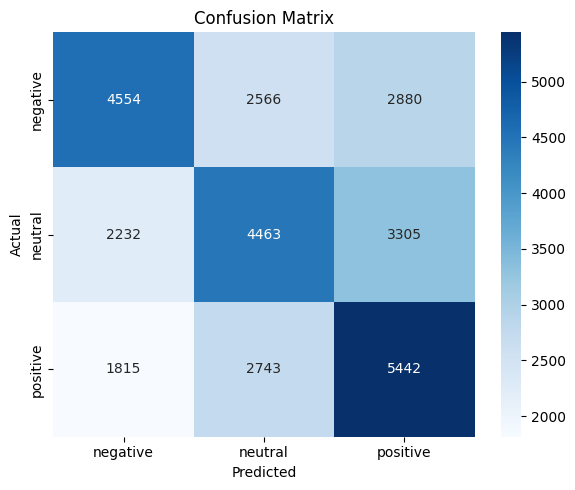


Misclassified examples: 15541 out of 30000 (51.8%)

Sample misclassifications:

Original: जितेंद्र जोशी निशिकांत म्हणून एक विलक्षण कामगिरी बजावते...
English:  As the center is active, an observation work is done...
Gold: positive -> Predicted: negative
Scores - Pos: 0.375, Neg: 0.500

Original: त्यांनी मला विचारले, जे मी कधीच केटर केले नाही म्हणून छान आहे ... आणि मला पैशांच...
English:  They asked me what I've never done because I've never been castered... and I nee...
Gold: positive -> Predicted: negative
Scores - Pos: 0.250, Neg: 1.500

Original: चित्रपट पाहावा की नाही?जर, तुम्ही विद्या बालनचा ;कहानी; चित्रपट पाहिला असेल आणि ...
English:  Look at the movie?If you're going to see a student ball; Kahani; if you're going...
Gold: negative -> Predicted: neutral
Scores - Pos: 0.375, Neg: 0.375

Original: तो माझ्या मशीनवरील संदेश पुसून टाकत असतो, ज्यामुळे मी निराश होतो...
English:  He throws a message out of my machine, and I get discouraged...
Gold: negative -> Predicted: positive
Scores

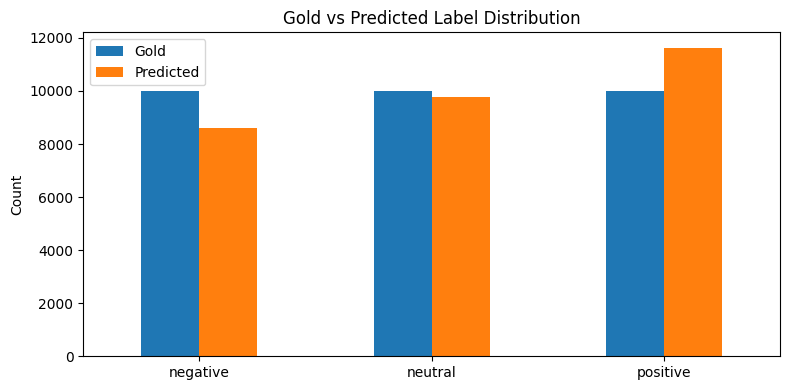


Evaluation completed. Metrics summary:
accuracy: 0.48196666666666665
evaluation_samples: 30000


{'accuracy': 0.48196666666666665,
 'evaluation_samples': 30000,
 'per_class': {'negative': {'precision': 0.5294733170561563,
   'recall': 0.4554,
   'f1': 0.48965109402720286,
   'support': 10000},
  'neutral': {'precision': 0.456713057715923,
   'recall': 0.4463,
   'f1': 0.4514464899858386,
   'support': 10000},
  'positive': {'precision': 0.4680485077836071,
   'recall': 0.5442,
   'f1': 0.5032598141212373,
   'support': 10000}}}

In [14]:
# =====================
# 5. Evaluation
# =====================

# Define valid sentiment labels
valid_labels = {'positive', 'negative', 'neutral'}

# Filter evaluation dataset to only rows with valid gold labels
_eval_df = merged[merged['label'].isin(valid_labels)].copy()
print(f"Evaluation rows: {_eval_df.shape[0]} / {merged.shape[0]}")

# Check if we have enough data for evaluation
if _eval_df.empty:
    print('No valid gold labels to evaluate.')
    print('Available labels in dataset:')
    print(merged['label'].value_counts(dropna=False))
    
    # Create dummy metrics for consistency
    metrics_summary = {
        'accuracy': 0.0,
        'note': 'No valid gold labels for evaluation',
        'per_class': {}
    }
    
elif len(_eval_df) < 3:
    print(f'Only {len(_eval_df)} evaluation samples - too few for meaningful evaluation.')
    metrics_summary = {
        'accuracy': 0.0,
        'note': 'Insufficient evaluation samples',
        'per_class': {}
    }
    
else:
    print('Performing evaluation...')
    
    gold = _eval_df['label']
    pred = _eval_df['predicted_label']
    
    # Check if predictions contain valid labels
    pred_labels_set = set(pred.unique())
    invalid_preds = pred_labels_set - valid_labels
    if invalid_preds:
        print(f"Warning: Found invalid predicted labels: {invalid_preds}")
        # Filter out invalid predictions
        valid_mask = pred.isin(valid_labels)
        _eval_df = _eval_df[valid_mask]
        gold = _eval_df['label']
        pred = _eval_df['predicted_label']
        print(f"Filtered to {len(_eval_df)} rows with valid predictions")
    
    if len(_eval_df) == 0:
        print('No valid predictions to evaluate.')
        metrics_summary = {'accuracy': 0.0, 'note': 'No valid predictions'}
    else:
        try:
            # Calculate metrics
            acc = accuracy_score(gold, pred)
            
            # Get unique labels present in both gold and pred for proper indexing
            present_labels = sorted(list(set(gold.unique()) | set(pred.unique())))
            present_labels = [lbl for lbl in present_labels if lbl in valid_labels]
            
            precision, recall, f1, support = precision_recall_fscore_support(
                gold, pred, labels=present_labels, zero_division=0
            )
            
            report = classification_report(gold, pred, digits=4, zero_division=0)
            cm = confusion_matrix(gold, pred, labels=present_labels)

            print(f"Accuracy: {acc:.4f}")
            print('\nClassification Report:')
            print(report)

            # Plot confusion matrix
            if len(present_labels) > 1:
                try:
                    fig, ax = plt.subplots(figsize=(6, 5))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                               xticklabels=present_labels, yticklabels=present_labels, ax=ax)
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('Actual')
                    ax.set_title('Confusion Matrix')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Could not create confusion matrix plot: {e}")

            # Error analysis
            errors = _eval_df[_eval_df['label'] != _eval_df['predicted_label']]
            print(f"\nMisclassified examples: {len(errors)} out of {len(_eval_df)} ({len(errors)/len(_eval_df)*100:.1f}%)")
            
            if len(errors) > 0:
                print("\nSample misclassifications:")
                error_cols = ['text', 'english_text', 'label', 'predicted_label', 'pos_score', 'neg_score']
                available_cols = [col for col in error_cols if col in errors.columns]
                
                sample_errors = errors[available_cols].head(5)
                for idx, row in sample_errors.iterrows():
                    print(f"\nOriginal: {row['text'][:80]}...")
                    if 'english_text' in row:
                        print(f"English:  {row['english_text'][:80]}...")
                    print(f"Gold: {row['label']} -> Predicted: {row['predicted_label']}")
                    if 'pos_score' in row and 'neg_score' in row:
                        print(f"Scores - Pos: {row['pos_score']:.3f}, Neg: {row['neg_score']:.3f}")
            
            # Label-wise analysis
            print("\nPer-label performance:")
            for i, lbl in enumerate(present_labels):
                if i < len(precision):
                    print(f"{lbl}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

            # Create metrics summary
            metrics_summary = {
                'accuracy': float(acc),
                'evaluation_samples': len(_eval_df),
                'per_class': {}
            }
            
            for i, lbl in enumerate(present_labels):
                if i < len(precision):
                    metrics_summary['per_class'][lbl] = {
                        'precision': float(precision[i]),
                        'recall': float(recall[i]),
                        'f1': float(f1[i]),
                        'support': int(support[i])
                    }
            
            # Add distribution comparison
            print("\nLabel distribution comparison:")
            gold_dist = gold.value_counts().sort_index()
            pred_dist = pred.value_counts().sort_index()
            
            dist_df = pd.DataFrame({
                'Gold': gold_dist,
                'Predicted': pred_dist
            }).fillna(0).astype(int)
            print(dist_df)
            
            # Simple visualization of distribution
            try:
                fig, ax = plt.subplots(figsize=(8, 4))
                dist_df.plot(kind='bar', ax=ax, rot=0)
                ax.set_title('Gold vs Predicted Label Distribution')
                ax.set_ylabel('Count')
                ax.legend()
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not create distribution plot: {e}")
                
        except Exception as e:
            print(f"Error during evaluation: {e}")
            metrics_summary = {
                'accuracy': 0.0,
                'error': str(e),
                'per_class': {}
            }

print(f"\nEvaluation completed. Metrics summary:")
for key, value in metrics_summary.items():
    if key != 'per_class':
        print(f"{key}: {value}")

metrics_summary

## Visualization
We generate word clouds for each predicted sentiment and a bar plot comparing gold vs predicted distribution.

Generating word clouds...
Predicted label distribution: {'positive': 11627, 'neutral': 9772, 'negative': 8601}
Saved English word cloud for positive to output\wordcloud_positive_english.png
Saved English word cloud for positive to output\wordcloud_positive_english.png
Saved Marathi word cloud for positive to output\wordcloud_positive_marathi.png
Saved Marathi word cloud for positive to output\wordcloud_positive_marathi.png
Saved English word cloud for negative to output\wordcloud_negative_english.png
Saved English word cloud for negative to output\wordcloud_negative_english.png
Saved Marathi word cloud for negative to output\wordcloud_negative_marathi.png
Saved Marathi word cloud for negative to output\wordcloud_negative_marathi.png
Saved English word cloud for neutral to output\wordcloud_neutral_english.png
Saved English word cloud for neutral to output\wordcloud_neutral_english.png
Saved Marathi word cloud for neutral to output\wordcloud_neutral_marathi.png
Saved Marathi word cloud f

C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ashpa\AppData\Local\Temp\ipykernel_26416\714277459.py:181: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from f

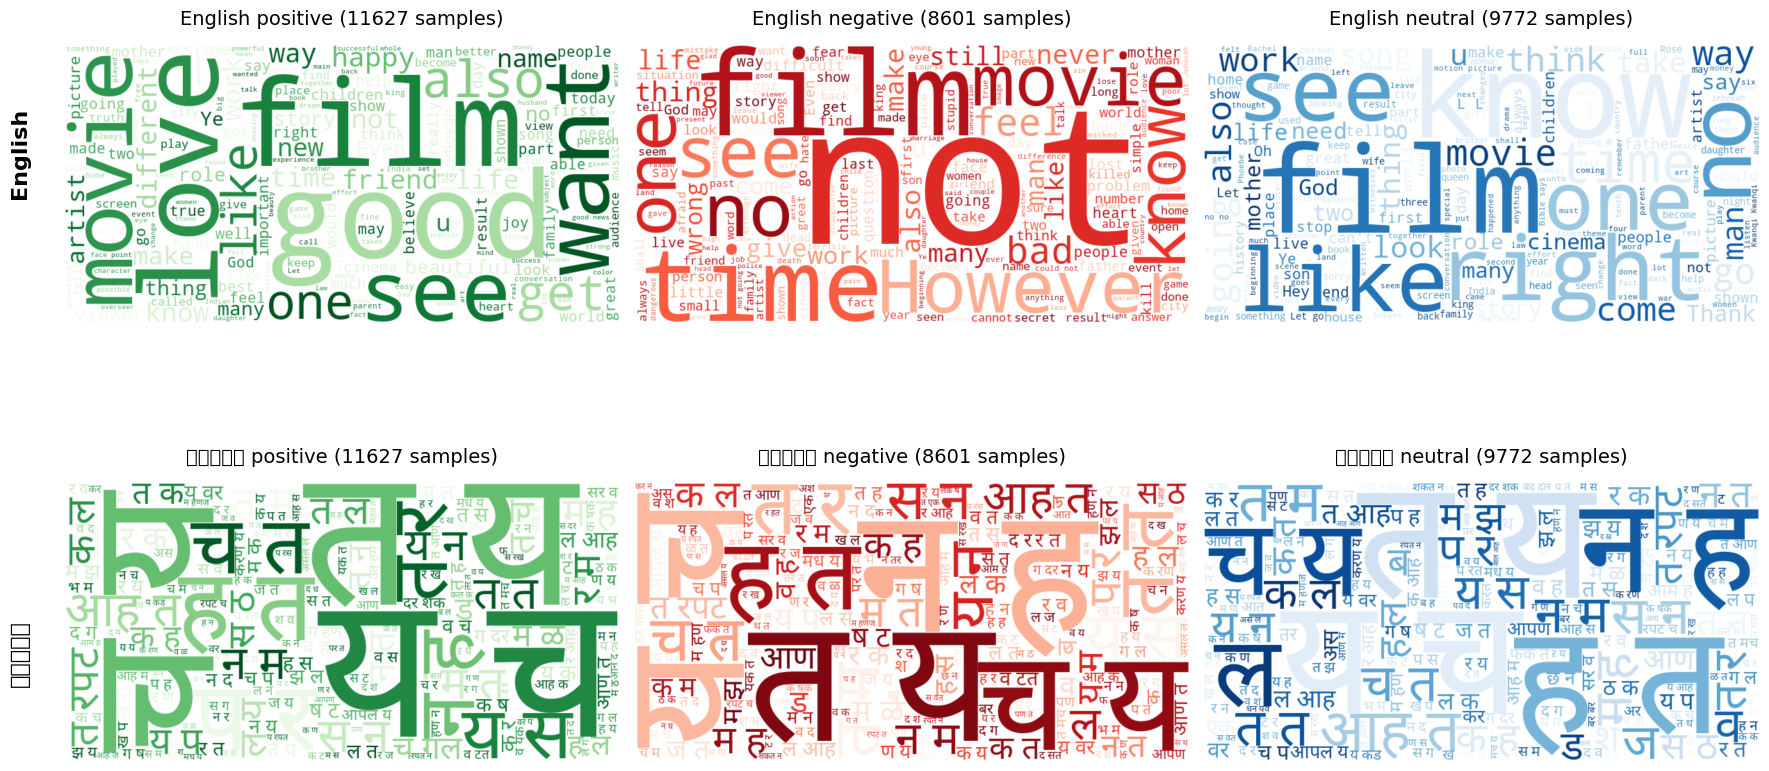


WordCloud generation completed!
Word cloud files saved: 6
  positive_english: output\wordcloud_positive_english.png
  positive_marathi: output\wordcloud_positive_marathi.png
  negative_english: output\wordcloud_negative_english.png
  negative_marathi: output\wordcloud_negative_marathi.png
  neutral_english: output\wordcloud_neutral_english.png
  neutral_marathi: output\wordcloud_neutral_marathi.png


{'positive_english': 'output\\wordcloud_positive_english.png',
 'positive_marathi': 'output\\wordcloud_positive_marathi.png',
 'negative_english': 'output\\wordcloud_negative_english.png',
 'negative_marathi': 'output\\wordcloud_negative_marathi.png',
 'neutral_english': 'output\\wordcloud_neutral_english.png',
 'neutral_marathi': 'output\\wordcloud_neutral_marathi.png'}

In [15]:
# =====================
# 6A. WordCloud Generation (English & Marathi)
# =====================

import warnings
warnings.filterwarnings('ignore', message='Glyph.*missing from current font')

print("Generating word clouds...")

# WordClouds by predicted label
wc_dir = OUTPUT_DIR
wc_paths = {}

# Define colors and labels for visualization
sentiment_config = [
    ('positive', 'Greens', '#2d8659'),
    ('negative', 'Reds', '#c41e3a'), 
    ('neutral', 'Blues', '#2e86ab')
]

try:
    # Check if we have predicted labels
    predicted_labels = merged['predicted_label'].value_counts()
    print(f"Predicted label distribution: {dict(predicted_labels)}")
    
    if len(predicted_labels) == 0:
        print("No predicted labels found. Skipping word cloud generation.")
        wc_paths = {}
    else:
        # Create word clouds for each sentiment - BOTH ENGLISH AND MARATHI
        num_labels = len([label for label, _, _ in sentiment_config if label in predicted_labels])
        if num_labels > 0:
            # Create figure with 2 rows: English (top), Marathi (bottom)
            fig, axes = plt.subplots(2, max(3, num_labels), figsize=(18, 10))
            if num_labels == 1:
                axes = axes.reshape(2, 1)
            elif num_labels == 2:
                axes = axes[:, :2]
            
            # Set the path to Devanagari font
            font_path = 'fonts/NotoSansDevanagari-Regular.ttf'
            
            for i, (label, cmap, color) in enumerate(sentiment_config):
                if i >= axes.shape[1]:
                    continue
                    
                subset = merged[merged['predicted_label'] == label]
                
                if len(subset) == 0 or label not in predicted_labels:
                    # No data for this label
                    axes[0, i].set_title(f"No English data for {label}")
                    axes[0, i].axis('off')
                    axes[1, i].set_title(f"No Marathi data for {label}")
                    axes[1, i].axis('off')
                    continue
                
                # ===== ENGLISH WORDCLOUD (TOP ROW) =====
                english_texts = subset['english_text'].dropna()
                # Filter out translation errors
                english_texts = english_texts[
                    ~english_texts.str.contains('<translation_failed|<empty_text>|<text_too_long>', na=False)
                ]
                
                english_blob = ' '.join(english_texts.astype(str))
                
                if english_blob.strip():
                    try:
                        # Create English word cloud
                        wc_english = WordCloud(
                            width=800, 
                            height=400, 
                            background_color='white',
                            colormap=cmap,
                            stopwords=EN_STOPWORDS,
                            max_words=200,
                            relative_scaling=0.5,
                            min_font_size=10
                        ).generate(english_blob)
                        
                        axes[0, i].imshow(wc_english, interpolation='bilinear')
                        axes[0, i].axis('off')
                        axes[0, i].set_title(f"English {label} ({len(subset)} samples)", fontsize=14, pad=15)
                        
                        # Save English word cloud
                        english_path = wc_dir / f'wordcloud_{label}_english.png'
                        wc_english.to_file(str(english_path))
                        wc_paths[f"{label}_english"] = str(english_path)
                        print(f"Saved English word cloud for {label} to {english_path}")
                        
                    except Exception as e:
                        print(f"Error creating English word cloud for {label}: {e}")
                        axes[0, i].set_title(f"Error: English {label}")
                        axes[0, i].axis('off')
                else:
                    axes[0, i].set_title(f"No valid English text for {label}")
                    axes[0, i].axis('off')
                
                # ===== MARATHI WORDCLOUD (BOTTOM ROW) =====
                marathi_texts = subset['text'].dropna()
                # Remove any empty or very short texts
                marathi_texts = marathi_texts[marathi_texts.str.len() > 2]
                
                # Simple preprocessing - just clean and join
                import re
                cleaned_texts = []
                for text in marathi_texts:
                    # Keep only Devanagari characters and spaces
                    clean_text = re.sub(r'[^\u0900-\u097F\s]', ' ', str(text))
                    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
                    if clean_text:
                        cleaned_texts.append(clean_text)
                
                marathi_blob = ' '.join(cleaned_texts)
                
                if marathi_blob.strip():
                    try:
                        # Create Marathi word cloud
                        wc_marathi = WordCloud(
                            font_path=font_path,  # Use Devanagari font for Marathi text
                            width=800, 
                            height=400, 
                            background_color='white',
                            colormap=cmap,
                            max_words=200,
                            relative_scaling=0.5,
                            min_font_size=10
                        ).generate(marathi_blob)
                        
                        axes[1, i].imshow(wc_marathi, interpolation='bilinear')
                        axes[1, i].axis('off')
                        axes[1, i].set_title(f"मराठी {label} ({len(subset)} samples)", fontsize=14, pad=15)
                        
                        # Save Marathi word cloud
                        marathi_path = wc_dir / f'wordcloud_{label}_marathi.png'
                        wc_marathi.to_file(str(marathi_path))
                        wc_paths[f"{label}_marathi"] = str(marathi_path)
                        print(f"Saved Marathi word cloud for {label} to {marathi_path}")
                        
                    except Exception as e:
                        print(f"Error creating Marathi word cloud for {label}: {e}")
                        print(f"Trying without font_path...")
                        try:
                            # Fallback without font specification
                            wc_marathi = WordCloud(
                                width=800, 
                                height=400, 
                                background_color='white',
                                colormap=cmap,
                                max_words=200,
                                relative_scaling=0.5,
                                min_font_size=10
                            ).generate(marathi_blob)
                            
                            axes[1, i].imshow(wc_marathi, interpolation='bilinear')
                            axes[1, i].axis('off')
                            axes[1, i].set_title(f"मराठी {label} ({len(subset)} samples)", fontsize=14, pad=15)
                            
                            # Save Marathi word cloud
                            marathi_path = wc_dir / f'wordcloud_{label}_marathi.png'
                            wc_marathi.to_file(str(marathi_path))
                            wc_paths[f"{label}_marathi"] = str(marathi_path)
                            print(f"Saved Marathi word cloud for {label} (fallback mode) to {marathi_path}")
                            
                        except Exception as e2:
                            print(f"Error creating fallback Marathi word cloud for {label}: {e2}")
                            axes[1, i].set_title(f"Error: मराठी {label}")
                            axes[1, i].axis('off')
                else:
                    axes[1, i].set_title(f"No valid Marathi text for {label}")
                    axes[1, i].axis('off')
            
            # Hide unused subplots
            for i in range(num_labels, axes.shape[1]):
                axes[0, i].axis('off')
                axes[1, i].axis('off')
            
            # Add row labels
            fig.text(0.02, 0.75, 'English', fontsize=16, fontweight='bold', rotation=90, va='center')
            fig.text(0.02, 0.25, 'मराठी', fontsize=16, fontweight='bold', rotation=90, va='center')
            
            plt.tight_layout()
            plt.subplots_adjust(left=0.05)  # Make room for row labels
            plt.show()
        else:
            print("No valid sentiment labels found for word cloud generation.")
            
except Exception as e:
    print(f"Error during word cloud generation: {e}")

print(f"\nWordCloud generation completed!")
print(f"Word cloud files saved: {len(wc_paths)}")
for label, path in wc_paths.items():
    print(f"  {label}: {path}")

wc_paths

### Balanced Word Clouds (English & Marathi)

This section generates balanced word clouds by sampling an equal number of tokens from positive, negative, and neutral sets for each language. Colors: Positive=green, Negative=red, Neutral=blue. Outputs are saved to `output/wordcloud_balanced_english.png` and `output/wordcloud_balanced_marathi.png` and recorded in `wc_paths`.

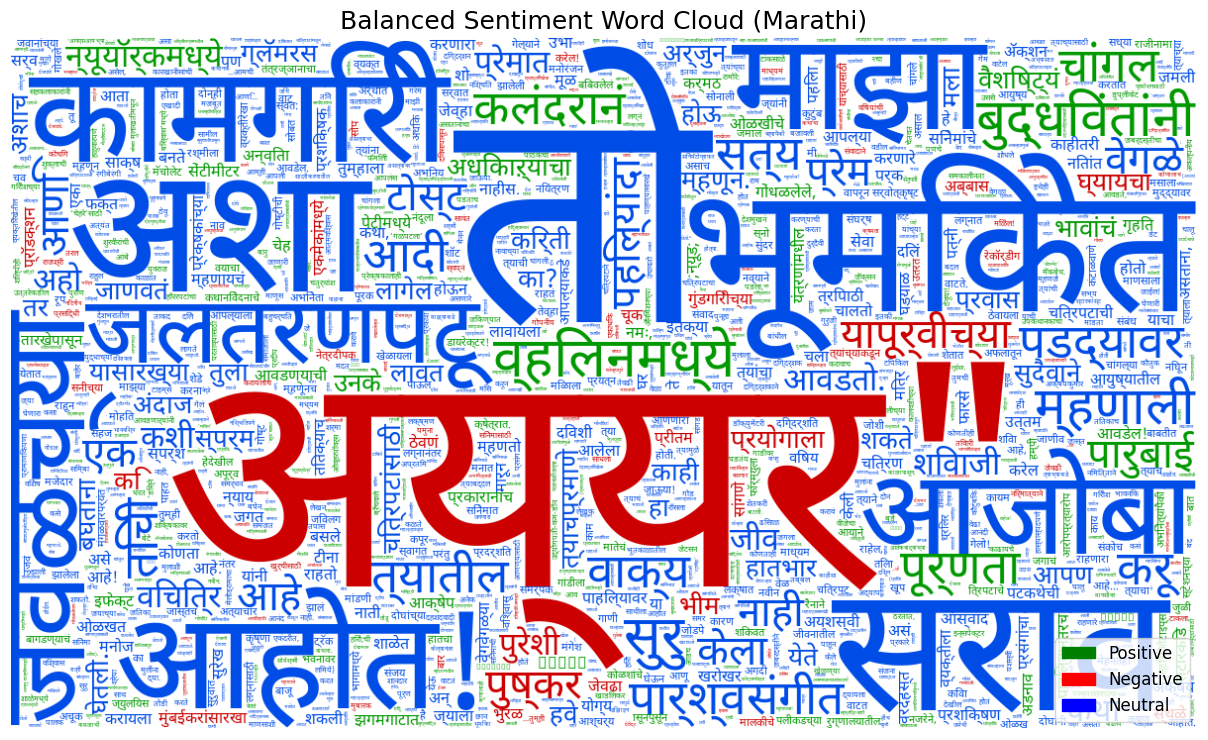

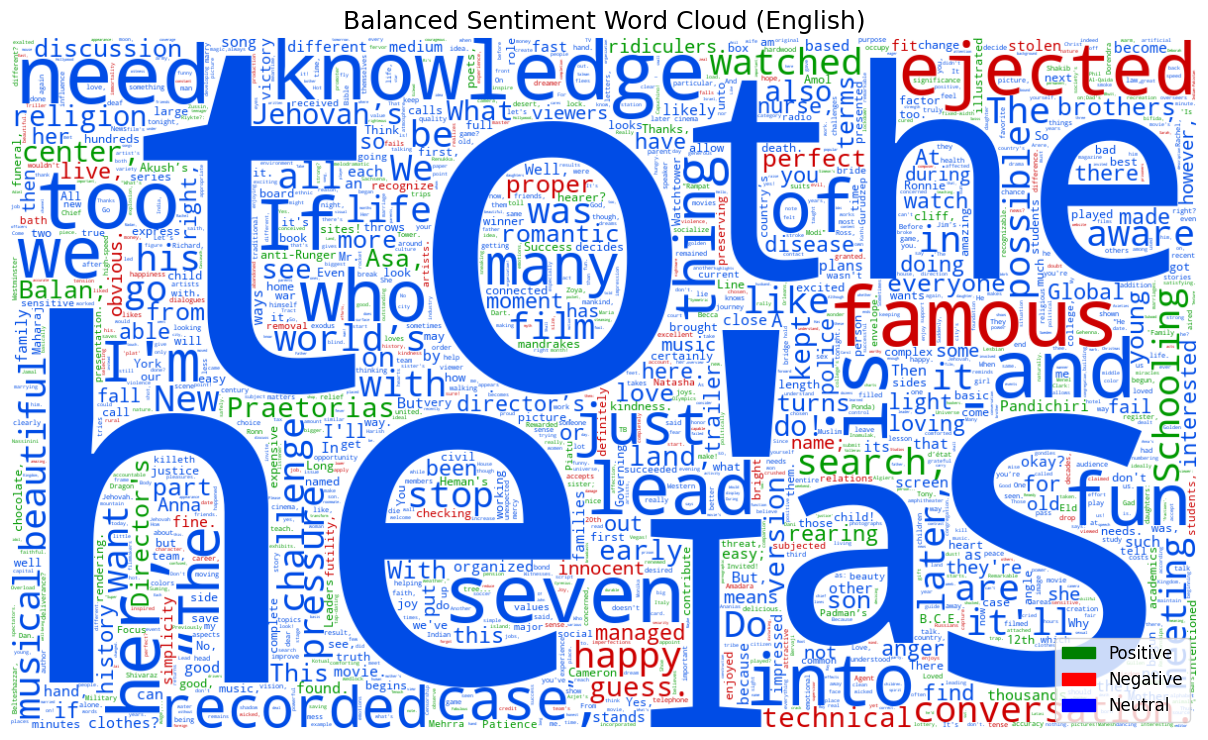

Balanced word cloud paths: output\wordcloud_balanced_marathi.png output\wordcloud_balanced_english.png


In [18]:
# Balanced Word Clouds for English and Marathi (equal token samples per sentiment)
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
from pathlib import Path

try:
    wc_paths
except NameError:
    wc_paths = {}

COLORS = {"positive": "hsl(120, 100%, 30%)",  # green
          "negative": "hsl(0, 100%, 40%)",    # red
          "neutral":  "hsl(220, 100%, 45%)"}  # blue

random.seed(SEED if 'SEED' in globals() else 42)

# Devanagari font path for Marathi
_font_candidates = [Path('fonts')/ 'NotoSansDevanagari-Regular.ttf', Path.cwd() / 'NotoSansDevanagari-Regular.ttf']
font_path = None
for _p in _font_candidates:
    try:
        if _p.exists():
            font_path = str(_p)
            break
    except Exception:
        pass

label_col = 'predicted_label'
text_col_mar = 'text'
text_col_eng = 'english_text'

if label_col not in merged.columns:
    print("predicted_label column missing; skipping balanced word clouds.")
else:
    def collect_tokens(series):
        return [t.strip() for t in ' '.join(series.dropna().astype(str)).split() if t.strip()]

    # Marathi tokens
    pos_mar = collect_tokens(merged.loc[merged[label_col]== 'positive', text_col_mar])
    neg_mar = collect_tokens(merged.loc[merged[label_col]== 'negative', text_col_mar])
    neu_mar = collect_tokens(merged.loc[merged[label_col]== 'neutral',  text_col_mar])

    # English tokens (filter placeholders)
    if text_col_eng in merged.columns:
        valid_eng = merged[text_col_eng].replace({'<not_translated>': '', '<no_translation_available>': '', '<translation_failed>': ''})
        pos_eng = collect_tokens(valid_eng[merged[label_col]== 'positive'])
        neg_eng = collect_tokens(valid_eng[merged[label_col]== 'negative'])
        neu_eng = collect_tokens(valid_eng[merged[label_col]== 'neutral'])
    else:
        pos_eng = neg_eng = neu_eng = []

    def build_balanced_freq(pos_list, neg_list, neu_list):
        min_len = min(len(pos_list), len(neg_list), len(neu_list))
        if min_len == 0:
            return None, None
        pos_sample = random.sample(pos_list, min_len)
        neg_sample = random.sample(neg_list, min_len)
        neu_sample = random.sample(neu_list, min_len)
        freqs, color_map = {}, {}
        for w in pos_sample:
            freqs[w] = 1; color_map[w] = 'positive'
        for w in neg_sample:
            freqs[w] = 1; color_map[w] = 'negative'
        for w in neu_sample:
            freqs[w] = 1; color_map[w] = 'neutral'
        return freqs, color_map

    def color_func_factory(color_map):
        def _color(word, **kwargs):
            return COLORS.get(color_map.get(word, 'neutral'), COLORS['neutral'])
        return _color

    def gen_and_show(freqs, color_map, title, out_name, use_font=None, stopwords=None):
        wc = WordCloud(
            width=1200, height=700, background_color='white',
            font_path=use_font, stopwords=stopwords or STOPWORDS,
            prefer_horizontal=0.9, max_words=max(200, 3*len(freqs)),
            color_func=color_func_factory(color_map)
        ).generate_from_frequencies(freqs)
        plt.figure(figsize=(16, 9))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=18)
        pos_patch = mpatches.Patch(color='green', label='Positive')
        neg_patch = mpatches.Patch(color='red', label='Negative')
        neu_patch = mpatches.Patch(color='blue', label='Neutral')
        plt.legend(handles=[pos_patch, neg_patch, neu_patch], loc='lower right', fontsize=12)
        plt.show()
        try:
            out_file = OUTPUT_DIR / out_name
            wc.to_file(str(out_file))
            return str(out_file)
        except Exception as e:
            print(f"Could not save {out_name}: {e}")
            return None

    # Marathi balanced
    freqs_mar, cmap_mar = build_balanced_freq(pos_mar, neg_mar, neu_mar)
    if freqs_mar:
        out_mar = gen_and_show(
            freqs_mar, cmap_mar,
            'Balanced Sentiment Word Cloud (Marathi)',
            'wordcloud_balanced_marathi.png', use_font=font_path,
            stopwords=EN_STOPWORDS
        )
        if out_mar:
            wc_paths['balanced_marathi'] = out_mar
    else:
        print('Skipping Marathi balanced word cloud (insufficient tokens per class).')

    # English balanced
    freqs_eng, cmap_eng = build_balanced_freq(pos_eng, neg_eng, neu_eng)
    if freqs_eng and sum(len(x) for x in [pos_eng, neg_eng, neu_eng])>0:
        out_eng = gen_and_show(
            freqs_eng, cmap_eng,
            'Balanced Sentiment Word Cloud (English)',
            'wordcloud_balanced_english.png', use_font=None,
            stopwords=STOPWORDS
        )
        if out_eng:
            wc_paths['balanced_english'] = out_eng
    else:
        print('Skipping English balanced word cloud (insufficient tokens per class).')

print('Balanced word cloud paths:', wc_paths.get('balanced_marathi'), wc_paths.get('balanced_english'))

Creating label distribution plot...


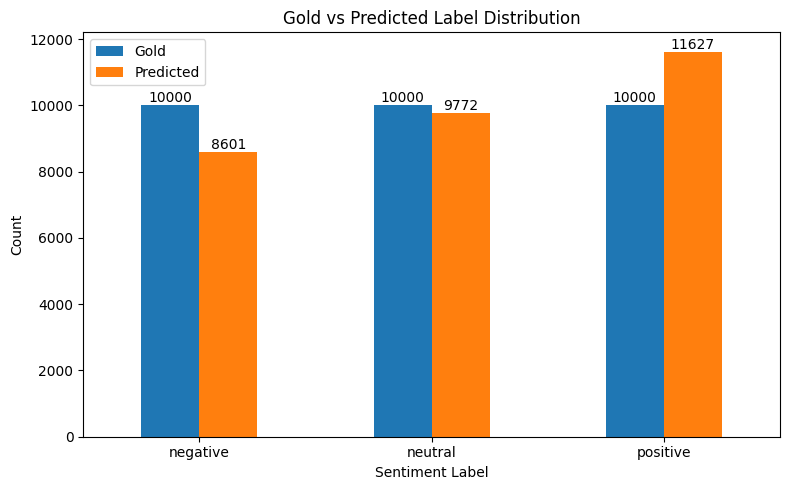

Label distribution plot completed!


In [10]:
# =====================
# 6B. Label Distribution Plot
# =====================

print("Creating label distribution plot...")

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Get label counts
    count_pred = merged['predicted_label'].value_counts()
    
    # Check if we have gold labels
    if 'label' in merged.columns and not merged['label'].isna().all():
        count_gold = merged['label'].value_counts()
        all_labels = sorted(set(count_gold.index).union(count_pred.index))
        
        bar_df = pd.DataFrame({
            'Gold': [count_gold.get(l, 0) for l in all_labels],
            'Predicted': [count_pred.get(l, 0) for l in all_labels]
        }, index=all_labels)
        
        bar_df.plot(kind='bar', ax=ax, rot=0, color=['#1f77b4', '#ff7f0e'])
        ax.set_title('Gold vs Predicted Label Distribution')
        ax.legend()
    else:
        # Only predicted labels available
        count_pred.plot(kind='bar', ax=ax, rot=0, color='#ff7f0e')
        ax.set_title('Predicted Label Distribution')
    
    ax.set_ylabel('Count')
    ax.set_xlabel('Sentiment Label')
    
    # Add count labels on bars
    for i, patch in enumerate(ax.patches):
        height = patch.get_height()
        if height > 0:
            ax.text(patch.get_x() + patch.get_width()/2., height + 0.5,
                   f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating label distribution plot: {e}")

print("Label distribution plot completed!")

Creating sentiment score distributions...


C:\Users\ashpa\AppData\Local\Temp\ipykernel_484\743488358.py:27: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged[['pos_score', 'neg_score']].hist(ax=ax2, bins=20, alpha=0.7)


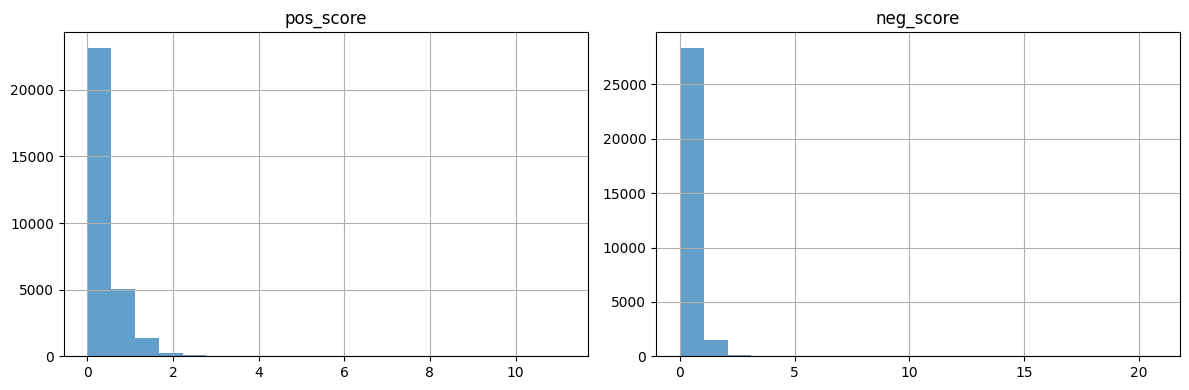

Sentiment score analysis completed!


In [11]:
# =====================
# 6C. Sentiment Score Distribution Analysis
# =====================

print("Creating sentiment score distributions...")

try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Positive vs Negative scores scatter plot
    ax1 = axes[0]
    colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
    for label in merged['predicted_label'].unique():
        if pd.notna(label):
            subset = merged[merged['predicted_label'] == label]
            ax1.scatter(subset['pos_score'], subset['neg_score'], 
                       c=colors.get(label, 'gray'), label=label, alpha=0.6)
    
    ax1.set_xlabel('Positive Score')
    ax1.set_ylabel('Negative Score')
    ax1.set_title('Sentiment Score Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Score histograms
    ax2 = axes[1]
    merged[['pos_score', 'neg_score']].hist(ax=ax2, bins=20, alpha=0.7)
    ax2.set_title('Score Histograms')
    ax2.set_xlabel('Score Value')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating score distribution plots: {e}")

print("Sentiment score analysis completed!")

## Visualization Summary

The visualization has been separated into three focused components:

1. **6A. WordCloud Generation**: Creates side-by-side English and Marathi wordclouds for each sentiment category
2. **6B. Label Distribution Plot**: Bar chart comparing gold vs predicted label distributions  
3. **6C. Sentiment Score Analysis**: Scatter plots and histograms showing score distributions

Each visualization can now be run independently, making the analysis more modular and easier to debug.

## Save Results
Persist processed dataset, metrics (JSON), word clouds, and translation cache to the `output/` directory.

In [12]:
# =====================
# 7. Save Artifacts
# =====================

print("Saving artifacts and results...")

# Ensure output directory exists
try:
    OUTPUT_DIR.mkdir(exist_ok=True)
    print(f"Output directory: {OUTPUT_DIR}")
except Exception as e:
    print(f"Warning: Could not create output directory: {e}")

saved_files = {}

# 1. Save main results CSV
try:
    # Select columns that exist in the dataframe
    available_cols = list(merged.columns)
    desired_cols = ['text', 'english_text', 'label', 'predicted_label', 
                   'pos_score', 'neg_score', 'obj_score', 'translation_ok', 'source']
    results_cols = [col for col in desired_cols if col in available_cols]
    
    results_path = OUTPUT_DIR / 'merged_sentiment_results.csv'
    merged[results_cols].to_csv(results_path, index=False, encoding='utf-8')
    saved_files['results_csv'] = str(results_path)
    print(f"✓ Saved results CSV ({len(merged)} rows, {len(results_cols)} columns): {results_path}")
except Exception as e:
    print(f"✗ Error saving results CSV: {e}")

# 2. Save metrics summary JSON
try:
    metrics_path = OUTPUT_DIR / 'metrics_summary.json'
    
    # Add dataset info to metrics
    if 'metrics_summary' in globals() and metrics_summary:
        enhanced_metrics = metrics_summary.copy()
    else:
        enhanced_metrics = {}
    
    enhanced_metrics.update({
        'dataset_info': {
            'total_samples': len(merged),
            'translation_success_rate': merged['translation_ok'].sum() / len(merged) if 'translation_ok' in merged.columns else 0,
            'predicted_distribution': dict(merged['predicted_label'].value_counts()),
            'processing_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }
    })
    
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(enhanced_metrics, f, ensure_ascii=False, indent=2)
    saved_files['metrics_json'] = str(metrics_path)
    print(f"✓ Saved metrics JSON: {metrics_path}")
except Exception as e:
    print(f"✗ Error saving metrics JSON: {e}")

# 3. Save confusion matrix plot (if evaluation was performed)
try:
    if '_eval_df' in globals() and not _eval_df.empty and len(_eval_df) > 0:
        cm_plot_path = OUTPUT_DIR / 'confusion_matrix.png'
        
        # Get unique labels for proper confusion matrix
        gold_labels = _eval_df['label'].unique()
        pred_labels = _eval_df['predicted_label'].unique()
        all_labels = sorted(list(set(gold_labels) | set(pred_labels)))
        
        if len(all_labels) > 1:
            cm = confusion_matrix(_eval_df['label'], _eval_df['predicted_label'], labels=all_labels)
            
            fig, ax = plt.subplots(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=all_labels, yticklabels=all_labels, ax=ax)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title('Confusion Matrix')
            plt.tight_layout()
            fig.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            saved_files['confusion_matrix'] = str(cm_plot_path)
            print(f"✓ Saved confusion matrix: {cm_plot_path}")
        else:
            print("⚠ Skipped confusion matrix (insufficient label diversity)")
    else:
        print("⚠ Skipped confusion matrix (no evaluation data)")
except Exception as e:
    print(f"✗ Error saving confusion matrix: {e}")

# 4. Save dataset statistics
try:
    stats_path = OUTPUT_DIR / 'dataset_statistics.json'
    
    # Collect comprehensive dataset statistics
    stats = {
        'overview': {
            'total_samples': len(merged),
            'unique_texts': merged['text'].nunique() if 'text' in merged.columns else 0,
            'sources': dict(merged['source'].value_counts()) if 'source' in merged.columns else {},
        },
        'labels': {
            'gold_distribution': dict(merged['label'].value_counts(dropna=False)) if 'label' in merged.columns else {},
            'predicted_distribution': dict(merged['predicted_label'].value_counts()) if 'predicted_label' in merged.columns else {}
        },
        'translation': {
            'success_rate': float(merged['translation_ok'].mean()) if 'translation_ok' in merged.columns else 0,
            'failed_translations': int((~merged['translation_ok']).sum()) if 'translation_ok' in merged.columns else 0
        },
        'sentiment_scores': {
            'positive_score_stats': {
                'mean': float(merged['pos_score'].mean()) if 'pos_score' in merged.columns else 0,
                'std': float(merged['pos_score'].std()) if 'pos_score' in merged.columns else 0,
                'min': float(merged['pos_score'].min()) if 'pos_score' in merged.columns else 0,
                'max': float(merged['pos_score'].max()) if 'pos_score' in merged.columns else 0
            },
            'negative_score_stats': {
                'mean': float(merged['neg_score'].mean()) if 'neg_score' in merged.columns else 0,
                'std': float(merged['neg_score'].std()) if 'neg_score' in merged.columns else 0,
                'min': float(merged['neg_score'].min()) if 'neg_score' in merged.columns else 0,
                'max': float(merged['neg_score'].max()) if 'neg_score' in merged.columns else 0
            }
        }
    }
    
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, ensure_ascii=False, indent=2)
    saved_files['dataset_stats'] = str(stats_path)
    print(f"✓ Saved dataset statistics: {stats_path}")
except Exception as e:
    print(f"✗ Error saving dataset statistics: {e}")

# 5. Ensure translation cache is saved
try:
    if 'translation_cache' in globals() and 'save_cache' in globals():
        if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
            saved_files['translation_cache'] = str(TRANSLATION_CACHE_PATH)
            print(f"✓ Final translation cache saved: {TRANSLATION_CACHE_PATH}")
        else:
            print("✗ Failed to save translation cache")
    else:
        print("⚠ Translation cache not available")
except Exception as e:
    print(f"✗ Error saving translation cache: {e}")

# 6. Include word cloud paths
if 'wc_paths' in globals() and wc_paths:
    saved_files['word_clouds'] = wc_paths
    print(f"✓ Word cloud files ({len(wc_paths)} files):")
    for label, path in wc_paths.items():
        print(f"    {label}: {path}")

# 7. Save file index for reference
try:
    file_index_path = OUTPUT_DIR / 'saved_files_index.json'
    with open(file_index_path, 'w', encoding='utf-8') as f:
        json.dump(saved_files, f, ensure_ascii=False, indent=2)
    print(f"✓ Saved file index: {file_index_path}")
except Exception as e:
    print(f"✗ Error saving file index: {e}")

# Summary
print(f"\n{'='*50}")
print("ARTIFACTS SAVED SUCCESSFULLY")
print(f"{'='*50}")
print(f"Total files saved: {len(saved_files)}")
for artifact_type, path in saved_files.items():
    if isinstance(path, dict):
        print(f"  {artifact_type}: {len(path)} files")
    else:
        print(f"  {artifact_type}: {path}")

print(f"\nAll artifacts saved to: {OUTPUT_DIR}")
print("Processing completed successfully!")

# Return saved files for reference
saved_files

Saving artifacts and results...
Output directory: output
✓ Saved results CSV (30000 rows, 9 columns): output\merged_sentiment_results.csv
✗ Error saving metrics JSON: Object of type int64 is not JSON serializable
✓ Saved results CSV (30000 rows, 9 columns): output\merged_sentiment_results.csv
✗ Error saving metrics JSON: Object of type int64 is not JSON serializable
✓ Saved confusion matrix: output\confusion_matrix.png
✗ Error saving dataset statistics: Object of type int64 is not JSON serializable
✓ Saved confusion matrix: output\confusion_matrix.png
✗ Error saving dataset statistics: Object of type int64 is not JSON serializable
✓ Final translation cache saved: translation_cache_offline.json
✓ Word cloud files (6 files):
    positive_english: output\wordcloud_positive_english.png
    positive_marathi: output\wordcloud_positive_marathi.png
    negative_english: output\wordcloud_negative_english.png
    negative_marathi: output\wordcloud_negative_marathi.png
    neutral_english: output

{'results_csv': 'output\\merged_sentiment_results.csv',
 'confusion_matrix': 'output\\confusion_matrix.png',
 'translation_cache': 'translation_cache_offline.json',
 'word_clouds': {'positive_english': 'output\\wordcloud_positive_english.png',
  'positive_marathi': 'output\\wordcloud_positive_marathi.png',
  'negative_english': 'output\\wordcloud_negative_english.png',
  'negative_marathi': 'output\\wordcloud_negative_marathi.png',
  'neutral_english': 'output\\wordcloud_neutral_english.png',
  'neutral_marathi': 'output\\wordcloud_neutral_marathi.png'}}

## Conclusion
This notebook established a transparent rule-based baseline for Marathi tweet/movie review sentiment by leveraging machine translation and SentiWordNet.

### Key Takeaways
- Translation quality directly impacts sentiment scoring
- SentiWordNet works better on standard English vocabulary; domain / slang terms are often OOV
- Neutral classification absorbs ambiguous low-margin cases

### Potential Improvements
1. Use better translation (IndicTrans2 or offline Marian models) to reduce noise
2. Lemmatize tokens before SentiWordNet lookup to improve coverage
3. Incorporate negation scope detection (e.g., reversing polarity within window after negation)
4. Add weighting by synset rank or average top-K synsets instead of first-sense heuristic
5. Compare with ML baselines: Logistic Regression / SVM using TF-IDF over English translations
6. Fine-tune transformer models (IndicBERT, mBERT, MuRIL) directly on Marathi without translation
7. Perform error clustering to identify systematic mistranslations

### Next Steps
You can now add a new section that trains a supervised classifier and compares metrics, or wrap this pipeline into a reusable Python module.

---
End of notebook.